<a href="https://colab.research.google.com/github/naimiaziz/ASHRAE---Great-Energy-Predictor-III/blob/master/deep_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import libraries
import json
import os, shutil
import cv2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import gc
%matplotlib inline 


In [0]:
# download dataset
# 1- get you kaggle token
# 2- install kaggle by typing pip install kaggle
# 3- create a file called kaggle.json where you write your username and token generated from kaggle in the following path "/root/.kaggle/"

!pip3 install --upgrade kaggle
!mkdir .kaggle
token = {"username":"aziznaimi","key":"19cc88fbc4b0581023539858b535761c"}
with open('/content/.kaggle/kaggle.json', 'w+') as file:
    json.dump(token, file)



Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


In [0]:
!cat /content/.kaggle/kaggle.json
!cp /content/.kaggle/kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!kaggle config set -n path -v /content
!kaggle competitions download -c ashrae-energy-prediction

{"username": "aziznaimi", "key": "19cc88fbc4b0581023539858b535761c"}- path is now set to: /content
 83% 73.0M/88.4M [00:01<00:00, 44.0MB/s]
100% 88.4M/88.4M [00:01<00:00, 63.1MB/s]
  0% 0.00/1.27M [00:00<?, ?B/s]
100% 1.27M/1.27M [00:00<00:00, 41.7MB/s]
 94% 113M/120M [00:02<00:00, 35.0MB/s]
100% 120M/120M [00:03<00:00, 41.5MB/s]
  0% 0.00/2.53M [00:00<?, ?B/s]
100% 2.53M/2.53M [00:00<00:00, 83.6MB/s]
  0% 0.00/44.5k [00:00<?, ?B/s]
100% 44.5k/44.5k [00:00<00:00, 45.1MB/s]
 98% 163M/167M [00:04<00:00, 29.0MB/s]
100% 167M/167M [00:04<00:00, 41.9MB/s]


In [0]:
#unzip files
!unzip /content/competitions/ashrae-energy-prediction/weather_test.csv.zip
!unzip /content/competitions/ashrae-energy-prediction/weather_train.csv.zip
!unzip /content/competitions/ashrae-energy-prediction/train.csv.zip
!unzip /content/competitions/ashrae-energy-prediction/test.csv.zip

Archive:  /content/competitions/ashrae-energy-prediction/weather_test.csv.zip
  inflating: weather_test.csv        
Archive:  /content/competitions/ashrae-energy-prediction/weather_train.csv.zip
  inflating: weather_train.csv       
Archive:  /content/competitions/ashrae-energy-prediction/train.csv.zip
  inflating: train.csv               
Archive:  /content/competitions/ashrae-energy-prediction/test.csv.zip
  inflating: test.csv                


In [0]:
!ls

import files to jupyter notebook

In [0]:
train = pd.read_csv("train.csv") 


In [0]:
weather_train=pd.read_csv("weather_train.csv") 

building=pd.read_csv('competitions/ashrae-energy-prediction/building_metadata.csv')

In [0]:
train = train.merge(building, on='building_id', how='left')

train = train.merge(weather_train, on=['site_id', 'timestamp'], how='left')
del weather_train,building 
gc.collect();


In [0]:
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


In [0]:
train.dtypes

building_id             int64
meter                   int64
timestamp              object
meter_reading         float64
site_id                 int64
primary_use            object
square_feet             int64
year_built            float64
floor_count           float64
air_temperature       float64
cloud_coverage        float64
dew_temperature       float64
precip_depth_1_hr     float64
sea_level_pressure    float64
wind_direction        float64
wind_speed            float64
dtype: object

# Data analysis

In [0]:
import plotly.express as px

px.scatter_matrix(train)

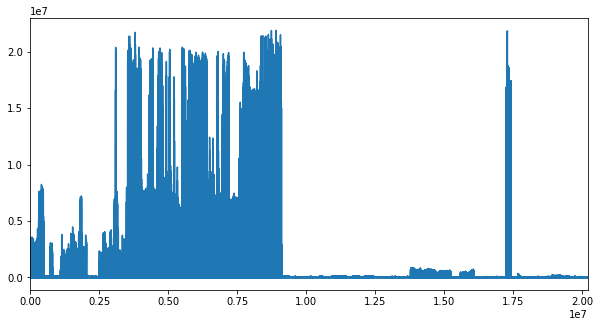

In [0]:
plt.figure(figsize = (10,5))

train.meter_reading.plot()


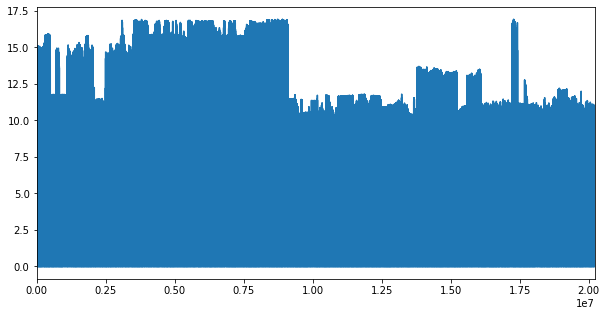

In [0]:
plt.figure(figsize = (10,5))
np.log1p(train.meter_reading).plot()

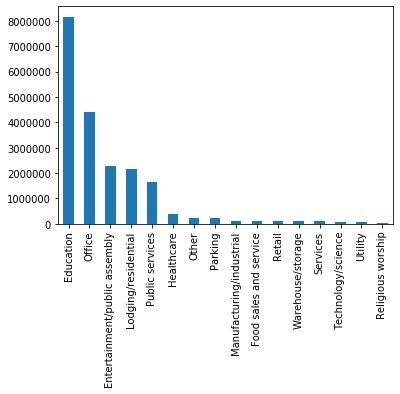

In [0]:
train.primary_use.value_counts().plot(kind='bar')


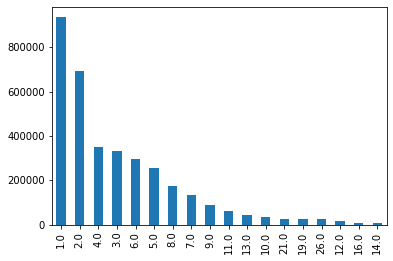

In [0]:
train.floor_count.value_counts().plot(kind="bar")

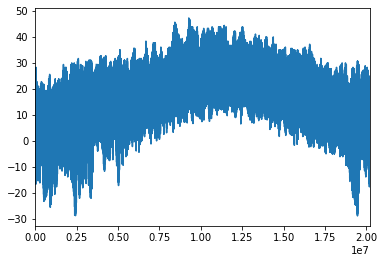

In [0]:
train.air_temperature.plot()

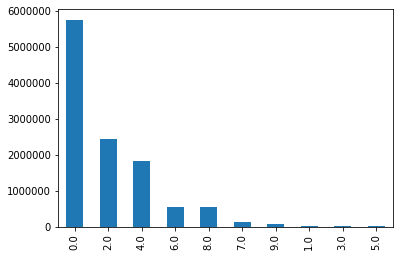

In [0]:
train.cloud_coverage.value_counts().plot(kind='bar')

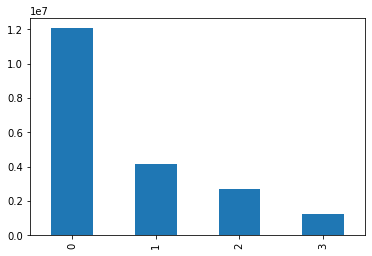

In [0]:
train.meter.value_counts().plot(kind='bar')

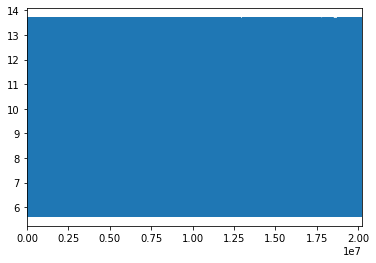

In [0]:
np.log(train.square_feet).plot()

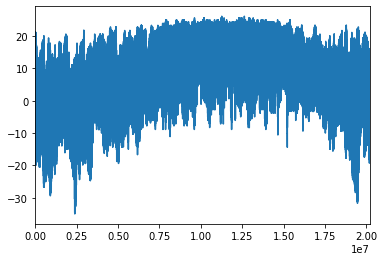

In [0]:
train.dew_temperature.plot()

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


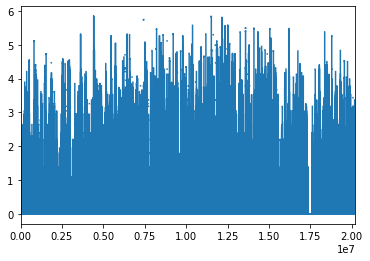

In [0]:
#feature should be modified
np.log1p(train.precip_depth_1_hr).plot()

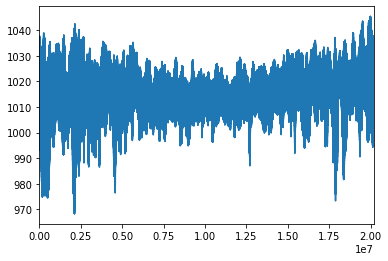

In [0]:
train.sea_level_pressure.plot()

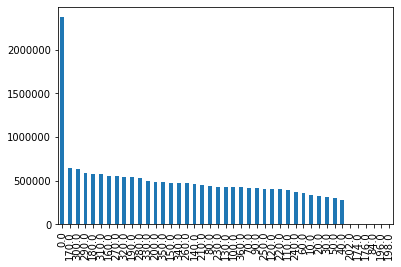

In [0]:
train.wind_direction.value_counts().plot(kind="bar")

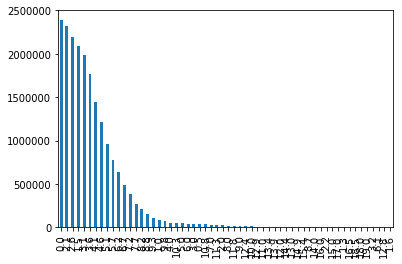

In [0]:
train.wind_speed.value_counts().plot(kind="bar")

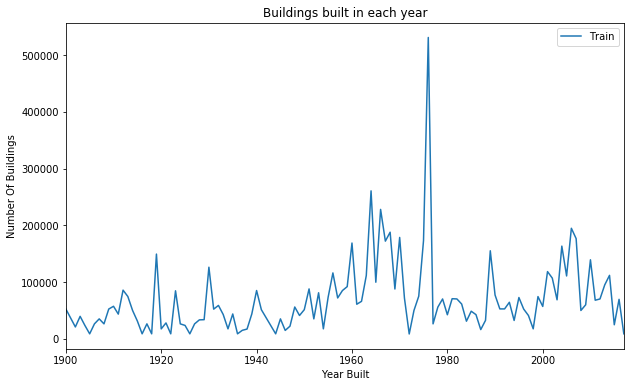

In [0]:
fig, ax = plt.subplots(1,1,figsize=(10, 6))
ax.set(xlabel='Year Built', ylabel='Number Of Buildings', title='Buildings built in each year')
train['year_built'].value_counts(dropna=False).sort_index().plot(ax=ax)

ax.legend(['Train']);

In [0]:
train.isna().sum()/train.shape[0]

building_id           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.599900
floor_count           0.826528
air_temperature       0.004781
cloud_coverage        0.436551
dew_temperature       0.004953
precip_depth_1_hr     0.185447
sea_level_pressure    0.060925
wind_direction        0.071678
wind_speed            0.007107
dtype: float64

# Feature engineering 

In [0]:
def fe(df):
  df["timestamp"] = pd.to_datetime(df["timestamp"])
  df["hour"] = df["timestamp"].dt.hour.astype(np.uint8)
  df["day"] = df["timestamp"].dt.day.astype(np.uint8)
  df["weekend"] = df["timestamp"].dt.weekday.astype(np.uint8)
  df["month"] = df["timestamp"].dt.month.astype(np.uint8)
  #df['square_feet']=df['square_feet'].map(np.log)
  #df['precip_depth_1_hr']=df['precip_depth_1_hr'].map(np.log1p)
  del df['floor_count']
  del df['year_built']
  
  del df["timestamp"]
  
  gc.collect();
  #del df['cloud_coverage']
  df=pd.concat([df,pd.get_dummies(df['primary_use'])],axis=1)
  df.air_temperature.fillna(method='ffill', inplace=True)
  df.dew_temperature.fillna(method='ffill', inplace=True)
  df.precip_depth_1_hr.fillna(method='bfill', inplace=True)
  df.cloud_coverage.fillna(method='ffill', inplace=True)
  df.sea_level_pressure.fillna(method='ffill', inplace=True)
  df.wind_direction .fillna(method='ffill', inplace=True)
  df.wind_speed.fillna(method='ffill', inplace=True)
  del df["primary_use"]
  return df

In [0]:
train=fe(train)
train.head()

,building_id,meter,meter_reading,site_id,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekend,month,Education,Entertainment/public assembly,Food sales and service,Healthcare,Lodging/residential,Manufacturing/industrial,Office,Other,Parking,Public services,Religious worship,Retail,Services,Technology/science,Utility,Warehouse/storage
0,0,0,0.0,0,7432,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,0,1,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0.0,0,2720,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,0,1,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0.0,0,5376,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,0,1,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0.0,0,23685,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,0,1,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0.0,0,116607,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,0,1,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
train.head(10)

,building_id,meter,meter_reading,site_id,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekend,month,Education,Entertainment/public assembly,Food sales and service,Healthcare,Lodging/residential,Manufacturing/industrial,Office,Other,Parking,Public services,Religious worship,Retail,Services,Technology/science,Utility,Warehouse/storage
0,0,0,0.0,0,7432,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,0,1,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0.0,0,2720,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,0,1,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0.0,0,5376,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,0,1,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0.0,0,23685,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,0,1,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0.0,0,116607,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,0,1,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,5,0,0.0,0,8000,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,0,1,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,6,0,0.0,0,27926,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,0,1,4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7,7,0,0.0,0,121074,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,0,1,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,8,0,0.0,0,60809,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,0,1,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,9,0,0.0,0,27000,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,0,1,4,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [0]:
train.isna().sum()/train.shape[0]

building_id                      0.0
meter                            0.0
meter_reading                    0.0
site_id                          0.0
square_feet                      0.0
air_temperature                  0.0
cloud_coverage                   0.0
dew_temperature                  0.0
precip_depth_1_hr                0.0
sea_level_pressure               0.0
wind_direction                   0.0
wind_speed                       0.0
hour                             0.0
day                              0.0
weekend                          0.0
month                            0.0
Education                        0.0
Entertainment/public assembly    0.0
Food sales and service           0.0
Healthcare                       0.0
Lodging/residential              0.0
Manufacturing/industrial         0.0
Office                           0.0
Other                            0.0
Parking                          0.0
Public services                  0.0
Religious worship                0.0
R

In [0]:

train.head()

,building_id,meter,meter_reading,site_id,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekend,month,Education,Entertainment/public assembly,Food sales and service,Healthcare,Lodging/residential,Manufacturing/industrial,Office,Other,Parking,Public services,Religious worship,Retail,Services,Technology/science,Utility,Warehouse/storage
0,0,0,0.0,0,7432,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,0,1,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0.0,0,2720,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,0,1,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0.0,0,5376,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,0,1,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0.0,0,23685,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,0,1,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0.0,0,116607,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,0,1,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
train.isna().sum()/train.shape[0]



building_id                      0.0
meter                            0.0
meter_reading                    0.0
site_id                          0.0
square_feet                      0.0
air_temperature                  0.0
cloud_coverage                   0.0
dew_temperature                  0.0
precip_depth_1_hr                0.0
sea_level_pressure               0.0
wind_direction                   0.0
wind_speed                       0.0
hour                             0.0
day                              0.0
weekend                          0.0
month                            0.0
Education                        0.0
Entertainment/public assembly    0.0
Food sales and service           0.0
Healthcare                       0.0
Lodging/residential              0.0
Manufacturing/industrial         0.0
Office                           0.0
Other                            0.0
Parking                          0.0
Public services                  0.0
Religious worship                0.0
R

In [0]:
train.air_temperature.fillna(method='ffill', inplace=True)
train.dew_temperature.fillna(method='ffill', inplace=True)
train.precip_depth_1_hr.fillna(method='bfill', inplace=True)
train.cloud_coverage.fillna(method='ffill', inplace=True)
train.sea_level_pressure.fillna(method='ffill', inplace=True)
train.wind_direction .fillna(method='ffill', inplace=True)
train.wind_speed.fillna(method='ffill', inplace=True)

In [0]:
train.head()

,building_id,meter,meter_reading,site_id,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekend,month,Education,Entertainment/public assembly,Food sales and service,Healthcare,Lodging/residential,Manufacturing/industrial,Office,Other,Parking,Public services,Religious worship,Retail,Services,Technology/science,Utility,Warehouse/storage
0,0,0,0.0,0,7432,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,0,1,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0.0,0,2720,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,0,1,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0.0,0,5376,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,0,1,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0.0,0,23685,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,0,1,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0.0,0,116607,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,0,1,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
train.head()

,building_id,meter,meter_reading,site_id,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekend,month,Education,Entertainment/public assembly,Food sales and service,Healthcare,Lodging/residential,Manufacturing/industrial,Office,Other,Parking,Public services,Religious worship,Retail,Services,Technology/science,Utility,Warehouse/storage
0,0,0,0.0,0,7432,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,0,1,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0.0,0,2720,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,0,1,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0.0,0,5376,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,0,1,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0.0,0,23685,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,0,1,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0.0,0,116607,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,0,1,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
target=np.log1p( train['meter_reading'])
del train['meter_reading']


# Training the model

importing keras

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,BatchNormalization,Dropout
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Using TensorFlow backend.


creating the *model*

In [0]:
model = Sequential()
model.add(Dense(12, input_dim=train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))
model.summary()
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                384       
_________________________________________________________________
batch_normalization_1 (Batch (None, 12)                48        
_________________________________________________________________
dropout_1 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 104       
_________________________________________________________________
batch_normalization_2 (Batch (None, 8)                 32        
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         


In [0]:
bestmodel="model.h5"
es = EarlyStopping(monitor='loss', min_delta=0.0001, patience=5, verbose=True, mode='min', restore_best_weights=True)
mc = ModelCheckpoint(bestmodel, monitor='loss', mode='min',verbose=True, save_best_only=True)

history = model.fit(train, target, epochs=60, batch_size=1024,  verbose=1, validation_split=0.2,callbacks=[es, mc])






Train on 16172880 samples, validate on 4043220 samples
Epoch 1/60





16172880/16172880 [==============================] - 68s 4us/step - loss: 4.1451 - mean_squared_error: 4.1451 - mean_absolute_error: 1.5208 - val_loss: 3.4863 - val_mean_squared_error: 3.4863 - val_mean_absolute_error: 1.3970

Epoch 00001: loss improved from inf to 4.14511, saving model to model.h5
Epoch 2/60
16172880/16172880 [==============================] - 70s 4us/step - loss: 3.7871 - mean_squared_error: 3.7871 - mean_absolute_error: 1.4361 - val_loss: 3.4156 - val_mean_squared_error: 3.4156 - val_mean_absolute_error: 1.3694

Epoch 00002: loss improved from 4.14511 to 3.78715, saving model to model.h5
Epoch 3/60
16172880/16172880 [==============================] - 70s 4us/step - loss: 3.7526 - mean_squared_error: 3.7526 - mean_absolute_error: 1.4267 - val_loss: 3.4699 - val_mean_squared_error: 3.4699 - val_mean_absolute_error: 1.3678

Epoch 00003: loss improved from 3.78715 to 3.75264, saving model to model

Load the model

In [0]:
from keras.models import load_model
model=load_model('model.h5')

Load the test and use Feature engineering function

In [0]:
test=pd.read_csv("test.csv")
weather_test=pd.read_csv("weather_test.csv")
building=pd.read_csv('competitions/ashrae-energy-prediction/building_metadata.csv')
test=test.merge(building,on='building_id',how='left')
test=test.merge(weather_test,on=['site_id','timestamp'],how='left')
del building,weather_test
gc.collect()
test=fe(test)
del test['row_id']

Predict the values

In [0]:
target_test =np.expm1( model.predict(test, batch_size=1024))

Submission file

In [0]:
#!unzip /content/competitions/ashrae-energy-prediction/sample_submission.csv.zip
submission_file = pd.read_csv('sample_submission.csv')
submission_file ['meter_reading'] = target_test
submission_file.to_csv('submission.csv', index=False)

In [0]:
!kaggle competitions submit -c ashrae-energy-prediction -f submission.csv -m "Message"
